# Deep Learning Notebook - Image Classification
This example uses a VGG-16 model pretrained on the ImageNet dataset and trains it to classify images from the CIFAR10 dataset included with Keras/Tensorflow. The workflow can be used for other puproses by replacing the preprocessing with a custom dataset and the model call with an alternative architecture.

## Prepare session

### Install dependencies

In [1]:
!pip install -r requirements.txt

### Import packages

In [2]:
import glob

import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, ZeroPadding2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import *
from tensorflow.keras.losses import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.activations import *

import numpy as np
from sklearn.model_selection import train_test_split
from skimage import filters, transform
import skimage.io as io
import matplotlib.pyplot as plt

## Preprocess images
This section uses the CIFAR10 dataset as a demonstration, but can be replaced with custom preprocessing for the dataset of your choosing. If the output is compatible with the Keras, it can be piped into the training functions below. For information of Keras compatibility, see the [documentation](https://keras.io/api/preprocessing/image/).

### Load CIFAR10 and define classes
CIFAR10 consists of 32 x 32 RGB images in 10 classes

In [3]:
# Load CIFAR10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [4]:
# Define class names for label values
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(class_names)

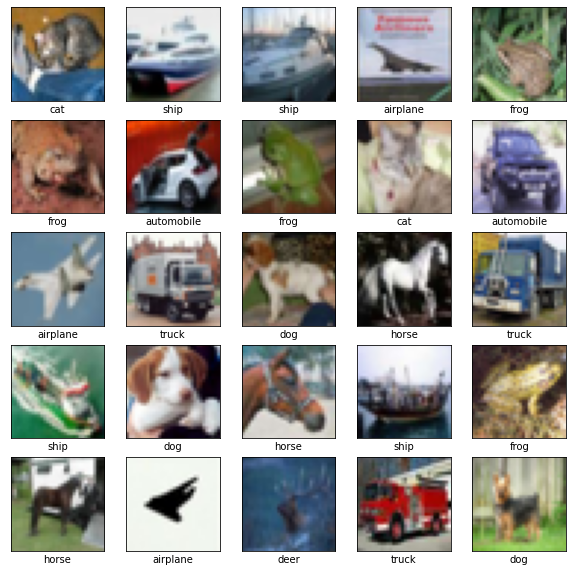

In [5]:
# Display example images with labels
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_test[i][0]])
plt.show()

### Reshape images, normalize pixel values between 0-1, and convert to one-hot classes

In [6]:
# Preprocess images
x_train = x_train/255.0
x_test = x_test/255.0

# Change classes to one-hot
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

## Create and train model

### Define models

#### Keras built-in applications
Keras contains [26 models](https://keras.io/api/applications/) (including popular architectures like VGG, ResNet, and Inception with varying depths) with pre-trained ImageNet weights available. These models require 3 channel inputs, so greyscale images must be stacked.

**Note:** Since the models were trained using ImageNet classification categories, the fully-connected layer(s) must be removed using `include_top = False` and replaced with a custom layer.

#### Customizable models
Some common model architectures (**VGG-16**, **LeNet-5**, **AlexNet**) are provided here for customization. These can accept single- or multi-channel input and can be customized as needed.

In [7]:
def vgg16(
    metrics,
    input_height=256, 
    input_width=256, 
    input_channels=3,  
    num_classes=1000, 
    dropout=None, 
    activation='relu', 
    weights_path=None,
    loss='categorical_crossentropy',
    optimizer=Adam(lr=0.001)
):
    model = Sequential()
    input_shape = (input_height, input_width, input_channels)

    model.add(Conv2D(64, 3, padding='same', input_shape=input_shape, activation=activation, name='conv1_1'))
    model.add(Conv2D(64, 3, padding='same', activation=activation, name='conv1_2'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Conv2D(128, 3, padding='same', activation=activation, name='conv2_1'))
    model.add(Conv2D(128, 3, padding='same', activation=activation, name='conv2_2'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Conv2D(256, 3, padding='same', activation=activation, name='conv3_1'))
    model.add(Conv2D(256, 3, padding='same', activation=activation, name='conv3_2'))
    model.add(Conv2D(256, 3, padding='same', activation=activation, name='conv3_3'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Conv2D(512, 3, padding='same', activation=activation, name='conv4_1'))
    model.add(Conv2D(512, 3, padding='same', activation=activation, name='conv4_2'))
    model.add(Conv2D(512, 3, padding='same', activation=activation, name='conv4_3'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Conv2D(512, 3, padding='same', activation=activation, name='conv5_1'))
    model.add(Conv2D(512, 3, padding='same', activation=activation, name='conv5_2'))
    model.add(Conv2D(512, 3, padding='same', activation=activation, name='conv5_3'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Flatten(name='flatten'))
    model.add(Dense(4096, activation=activation, name='dense_1'))
    model.add(Dropout(dropout))
    model.add(Dense(4096, activation=activation, name='dense_2'))
    model.add(Dropout(dropout))
    model.add(Dense(num_classes, activation='softmax'))

    if weights_path:
        model.load_weights(weightsPath)
        
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return model


def lenet(
    metrics,
    input_height=256, 
    input_width=256, 
    input_channels=3,  
    num_classes=10, 
    dropout=None, 
    activation='relu', 
    weights_path=None,
    loss='categorical_crossentropy',
    optimizer=SGD(lr=0.01, momentum=0.99)
):
    # Initialize model
    model = Sequential()
    input_shape = (input_height, input_width, input_channels)

    # Model layers
    model.add(Conv2D(16, 5, padding='same', input_shape=input_shape, activation=activation))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

    model.add(Conv2D(32, 5, padding='same', input_shape=input_shape, activation=activation))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(128, activation=activation))
    if dropout:
        model.add(Dropout(dropout))
    model.add(Dense(num_classes, activation='softmax'))

    # If network was pretrained and saved with weights only
    if weights_path:
        model.load_weights(weights_path)

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return model


def alexnet(
    metrics,
    input_height=227, 
    input_width=227, 
    input_channels=3,  
    num_classes=10, 
    dropout=0.5, 
    activation='relu', 
    weights_path=None,
    loss='categorical_crossentropy',
    optimizer=Adam(lr=0.001)
):
    # Initialize model
    model = Sequential()
    input_shape = (input_height, input_width, input_channels)
    
    # Model layers
    # First conv block
    model.add(Conv2D(96, 11, strides=(4,4), activation=activation))
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
    
    # Second conv block
    model.add(Conv2D(256, 5, strides=(1,1), padding='same', activation=activation))
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
    model.add(BatchNormalization())
    
    #Final conv block
    model.add(Conv2D(384, 3, strides=(1,1), padding='same', activation=activation))
    model.add(Conv2D(384, 3, strides=(1,1), padding='same', activation=activation))
    model.add(Conv2D(256, 3, strides=(1,1), padding='same', activation=activation))
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
    model.add(Dropout(dropout))
    
    # Fully-connected block (no output activation)
    model.add(Flatten())
    model.add(Dense(4096, activation=activation))
    model.add(Dropout(dropout))
    model.add(Dense(4096, activation=activation))
    model.add(Dropout(dropout))
    model.add(Dense(num_classes))
    
    if weights_path:
        model.load_weights(weights_path)

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return model
    

### Create a Mirrored Strategy
Running a model with a Tensorflow MirroredStrategy allows the model to be trained across multiple GPUs. It is still compatible with single GPU or CPU training, so this code can be run on any cluster. The amount of memory (RAM or GPU) available will affect the available batch size.   

In [8]:
# Create a MirroredStrategy.
strategy = tf.distribute.MirroredStrategy()
print(f'Number of devices: {strategy.num_replicas_in_sync}')


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


### Build or load model
In this example, we will use a VGG-16 model with pretrained ImageNet weights provided by Keras. The fully-connected layers are replaced by Dense layers of equivalent size, without weights, and output using the number of classes in the CIFAR10 dataset

In [9]:
input_shape = (32,32,3)
num_classes = 10
loss='categorical_crossentropy'
optimizer=SGD(lr=0.001, momentum=0.99)

# Open a strategy scope.
with strategy.scope():
    # Define metrics
    metrics = ['acc']
    
    # Instantiate built-in VGG-16 model with ImageNet weights but without the output layers (include_top=False)
    print('Loading model...')
    model = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    # Flatten the output
    flat = Flatten()(model.layers[-1].output)
    # Replace the connected layers with new ones of equivalent size
    dense1 = Dense(4096, activation='relu')(flat)
    dense2 = Dense(4096, activation='relu')(dense1)
    output = Dense(num_classes, activation='softmax')(dense2)
    
    model = Model(inputs=model.inputs, outputs=output)
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    print('Done')
    

Loading model...
Done


In [10]:
# Print the model structure to make sure everything looks good
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)        

### Train model
The model training setup validates the training weights in real time using the testing dataset

In [11]:
batch_size = 32
epoch_steps = len(x_train)/batch_size
epochs = 25

model_path = 'vgg16.h5'

# Train the model
print('Training model')
model_checkpoint = ModelCheckpoint(model_path, monitor='val_acc', verbose=1, save_best_only=True)
H = model.fit(x=x_train, y=y_train, validation_data=(x_test, y_test), batch_size=batch_size,
          steps_per_epoch=epoch_steps, epochs=epochs, callbacks=model_checkpoint)

Training model
Epoch 1/25
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/t

Epoch 24/25
1561/1562 [============================>.] - ETA: 0s - loss: 0.0436 - acc: 0.9861
Epoch 00024: val_acc did not improve from 0.86110
1563/1562 [==============================] - 23s 15ms/step - loss: 0.0437 - acc: 0.9861 - val_loss: 0.8439 - val_acc: 0.8567
Epoch 25/25
1561/1562 [============================>.] - ETA: 0s - loss: 0.0370 - acc: 0.9893
Epoch 00025: val_acc did not improve from 0.86110
1563/1562 [==============================] - 23s 15ms/step - loss: 0.0370 - acc: 0.9894 - val_loss: 0.8532 - val_acc: 0.8545


## Visualize model results

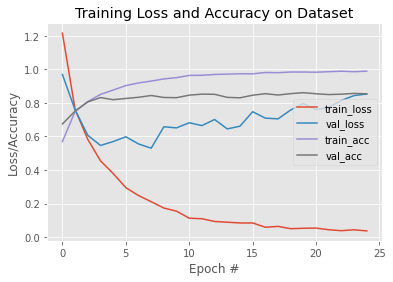

In [13]:
# plot the training loss and accuracy
N = 25
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="right")

### Predict classes for the test set

In [12]:
predict_results = model.predict(x_test, batch_size=32)

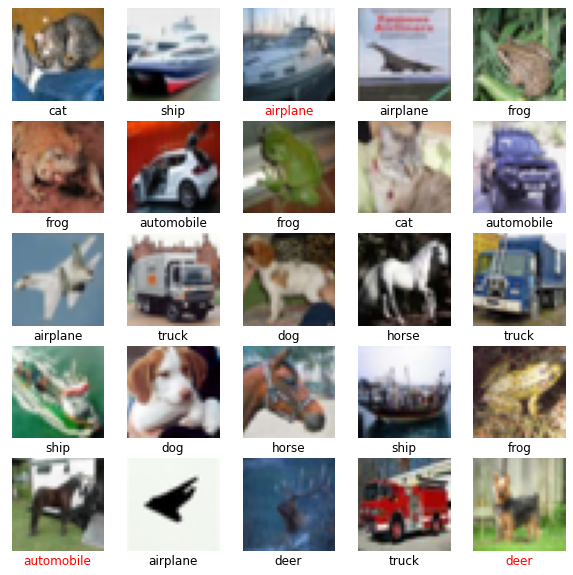

In [14]:
# Display example images with labels
# Red labels are incorrect
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test[i], cmap=plt.cm.binary)
    pred_class = np.argmax(predict_results[i])
    real_class = np.argmax(y_test[i])
    if pred_class == real_class: 
        plt.xlabel(class_names[pred_class], color='black')
    else:
        plt.xlabel(class_names[pred_class], color='red')
plt.show()